# PREDICTING THE ECONOMIC DAMAGE OF STORMS IN THE US

## 1.Importing and prepping data

### Importing libraries and csv files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import os
import shapefile
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 100)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# all the .csv I downloaded from the NCDC website are stored in the "data from NCDC" folder
csv_files = [f for f in os.listdir('data from NCDC/') if f.endswith('.csv')]
csv_files

['StormEvents_details-ftp_v1.0_d2013_c20170519.csv',
 'StormEvents_details-ftp_v1.0_d2008_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2001_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2005_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2002_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2006_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2010_c20170726.csv',
 'StormEvents_details-ftp_v1.0_d2017_c20180918.csv',
 'StormEvents_details-ftp_v1.0_d2016_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2015_c20180525.csv',
 'StormEvents_details-ftp_v1.0_d2011_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2014_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2007_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2003_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2018_c20180918.csv',
 'StormEvents_details-ftp_v1.0_d2009_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2012_c20170519.csv',
 'StormEvents_details-ftp_v1.0_d2004_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2000_c20170717

In [3]:
# after exploring the columns in such files, these are the ones I want to import
columns = ['STATE','CZ_TYPE','EVENT_TYPE','BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
           'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
           'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS','BEGIN_RANGE',
           'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH','MAGNITUDE_TYPE','MAGNITUDE',
           'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON']

### Transforming strings into numbers and feature engineering time-related variables

In [4]:
# defining the dictionary needed to transform the damage values from strings to numbers
damage_dict = {'K': 10**3, 'M': 10**6, 'B': 10**9, '0': 0 }

# initializing the dataframe
frames = []
df = pd.DataFrame()

for filename in csv_files:
    temp_df = pd.read_csv('data from NCDC/' + filename)
    temp_df = temp_df[columns]
    
    # assigning Hail to the missing magnitude types
    temp_df.loc[((temp_df['MAGNITUDE_TYPE'].isnull()) & (temp_df['MAGNITUDE'].isnull() == False)),'MAGNITUDE_TYPE'] = 'HA'
    
    # dropping rows that contain null values in one of the columns in the subset list
    temp_df = temp_df.dropna(subset = ['MAGNITUDE','BEGIN_LAT','DAMAGE_PROPERTY'])
    
    # filling in empy values of DAMAGE_CROPS with 0
    temp_df.loc[temp_df['DAMAGE_CROPS'].isnull(),'DAMAGE_CROPS'] = '0.00K'
    
    # feeature engineering the temporal variables
    temp_df['YEAR'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.year
    temp_df['BEGIN_MONTH'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.month
    temp_df['BEGIN_DAY'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.day
    temp_df['BEGIN_TIME'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.time
    temp_df['END_MONTH'] = pd.to_datetime(temp_df['END_DATE_TIME']).dt.month
    temp_df['END_DAY'] = pd.to_datetime(temp_df['END_DATE_TIME']).dt.day
    temp_df['END_TIME'] = pd.to_datetime(temp_df['END_DATE_TIME']).dt.time
    temp_df['DURATION_DAYS'] = (pd.to_datetime(temp_df['END_DATE_TIME']) - pd.to_datetime(temp_df['BEGIN_DATE_TIME'])).dt.days
    temp_df['DURATION_HOURS'] = (pd.to_datetime(temp_df['END_DATE_TIME']) - pd.to_datetime(temp_df['BEGIN_DATE_TIME'])).dt.seconds//3600
    temp_df['DURATION_MINUTES'] = ((pd.to_datetime(temp_df['END_DATE_TIME']) - pd.to_datetime(temp_df['BEGIN_DATE_TIME'])).dt.seconds//60)%60
    
    # transforming the damage variables from strings to float
    temp_df.loc[temp_df['DAMAGE_PROPERTY']=='0','DAMAGE_PROPERTY'] = '0.0'
    temp_df.loc[temp_df['DAMAGE_PROPERTY']=='K','DAMAGE_PROPERTY'] = '1K'
    temp_df['DAMAGE_PROPERTY'] = temp_df['DAMAGE_PROPERTY'].map(lambda x: float(x[:-1])*damage_dict[x[-1]])
    temp_df.loc[temp_df['DAMAGE_CROPS']=='0','DAMAGE_CROPS'] = '0.0'
    temp_df.loc[temp_df['DAMAGE_CROPS']=='K','DAMAGE_CROPS'] = '1K'
    temp_df['DAMAGE_CROPS'] = temp_df['DAMAGE_CROPS'].map(lambda x: float(x[:-1])*damage_dict[x[-1]])
    
    # adding the yearly df to the frames list
    frames.append(temp_df)

# generating unique dataframe from list of dataframes
df = pd.concat(frames)

# transfoming the begin_date_time to a time object to sort the df
df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])
df.sort_values('BEGIN_DATE_TIME', inplace = True)

# resetting the index
df.reset_index(inplace = True, drop = True)

# check
df.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATE,CZ_TYPE,EVENT_TYPE,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,MAGNITUDE_TYPE,MAGNITUDE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_MONTH,END_DAY,END_TIME,DURATION_DAYS,DURATION_HOURS,DURATION_MINUTES
0,MISSOURI,C,Thunderstorm Wind,2000-01-03 07:30:00,CST,03-JAN-00 07:30:00,0,0,0,0,3000.0,0.0,NaN,NaN,NaN,NaN,E,52.0,36.93,-90.75,36.83,-90.83,2000,1,3,07:30:00,1,3,07:30:00,0,0,0
1,MISSOURI,C,Thunderstorm Wind,2000-01-03 08:20:00,CST,03-JAN-00 08:20:00,0,0,0,0,3000.0,0.0,NaN,NaN,NaN,NaN,E,50.0,36.97,-90.55,37.13,-90.47,2000,1,3,08:20:00,1,3,08:20:00,0,0,0
2,MISSOURI,C,Thunderstorm Wind,2000-01-03 08:50:00,CST,03-JAN-00 09:00:00,3,0,0,0,250000.0,0.0,NaN,NaN,NaN,NaN,E,83.0,37.25,-89.67,37.30,-89.53,2000,1,3,08:50:00,1,3,09:00:00,0,0,10
3,ILLINOIS,C,Thunderstorm Wind,2000-01-03 09:18:00,CST,03-JAN-00 09:22:00,0,0,0,0,150000.0,0.0,2.0,NE,4.0,NE,E,100.0,37.73,-89.18,37.75,-89.17,2000,1,3,09:18:00,1,3,09:22:00,0,0,4
4,ILLINOIS,C,Thunderstorm Wind,2000-01-03 09:22:00,CST,03-JAN-00 09:24:00,0,0,0,0,100000.0,0.0,NaN,NaN,NaN,NaN,E,75.0,37.78,-89.12,37.78,-89.12,2000,1,3,09:22:00,1,3,09:24:00,0,0,2


In [5]:
# I want to keep all the rows where the damage is greater than 0, also because I will log-transform later on,
# so my target variable cannot be zero
df = df[df['DAMAGE_PROPERTY'] > 0]

### Checking if geospatial data make sense

In [6]:
# defining variables that I will for my map plot
events = list(df['EVENT_TYPE'].value_counts().index)
colors = ['k','y','tomato','cornflowerblue','orchid','b','lime']
sf = shapefile.Reader('maps/US shape files/tl_2010_us_state10')

In [7]:
def map_plot(df):
    ax = plt.axes()
    for shape in list(sf.iterShapes()):
        x_lon = np.zeros((len(shape.points),1))
        y_lat = np.zeros((len(shape.points),1))
        for ip in range(len(shape.points)):
           x_lon[ip] = shape.points[ip][0]
           y_lat[ip] = shape.points[ip][1]
        plt.plot(x_lon,y_lat, c = 'k', lw = 2)
    #plt.figure(figsize=(20,15))
    for ev, col in zip(events, colors):
        plt.scatter(df.loc[df['EVENT_TYPE'] == ev,'BEGIN_LON'], 
                    df.loc[df['EVENT_TYPE'] == ev,'BEGIN_LAT'], 
                    c=col, alpha = 0.5, label = ev, s = 40)

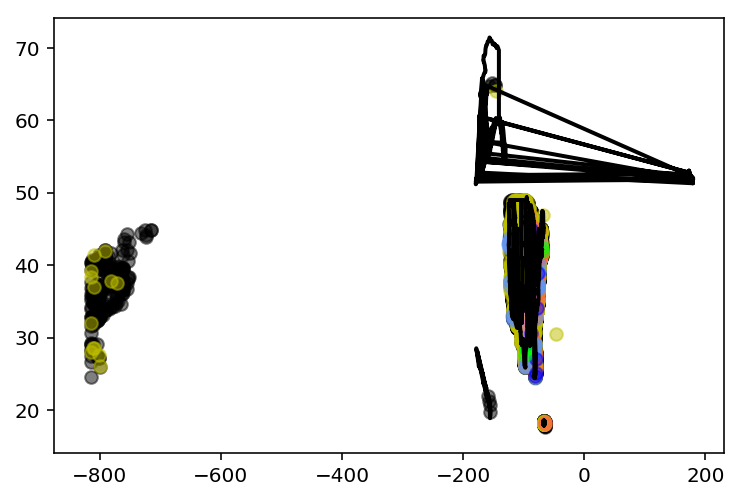

In [8]:
map_plot(df)

### Isolating points outside the US map and fixing them

In [9]:
top = 71.349492 # north lat
left = -200 # west long
right = 0 # east long
bottom =  0 # south lat
idx_list = []
for index, row in df.iterrows():
    if (df.loc[index,'BEGIN_LAT'] <= bottom)| (df.loc[index,'BEGIN_LAT']>= top) | (df.loc[index,'BEGIN_LON'] <= left) | (df.loc[index,'BEGIN_LON'] >= right)|(df.loc[index,'END_LAT'] <= bottom)| (df.loc[index,'END_LAT']>= top) | (df.loc[index,'END_LON'] <= left) | (df.loc[index,'END_LON'] >= right):
        idx_list.append(index)
len(idx_list)

303

In [10]:
lon_lat_columns = ['BEGIN_LAT','BEGIN_LON', 'END_LON', 'END_LAT']
df.loc[(idx_list), 'STATE'].value_counts()

VIRGINIA          77
NORTH CAROLINA    53
PENNSYLVANIA      43
SOUTH CAROLINA    37
FLORIDA           22
MARYLAND          19
OHIO              15
NEW YORK          12
WEST VIRGINIA     11
GEORGIA            9
VERMONT            5
Name: STATE, dtype: int64

In [11]:
for idx in idx_list:
    for col in lon_lat_columns:
        if abs(df.loc[idx,col])>100:
            df.loc[idx,col] = df.loc[idx,col]/10

df.loc[idx_list, lon_lat_columns]

,BEGIN_LAT,BEGIN_LON,END_LON,END_LAT
641,27.17,-80.113,-80.113,27.17
1125,40.55,-75.400,-75.480,40.62
1307,35.90,-77.405,-77.405,35.90
2457,38.18,-76.507,-76.507,38.18
2720,34.30,-79.010,-79.010,34.30
3028,37.90,-76.400,-76.400,37.90
3067,36.02,-81.007,-81.080,35.90
3166,37.78,-78.002,-78.002,37.78
3182,37.73,-77.215,-77.215,37.73
3189,37.18,-77.108,-77.108,37.18


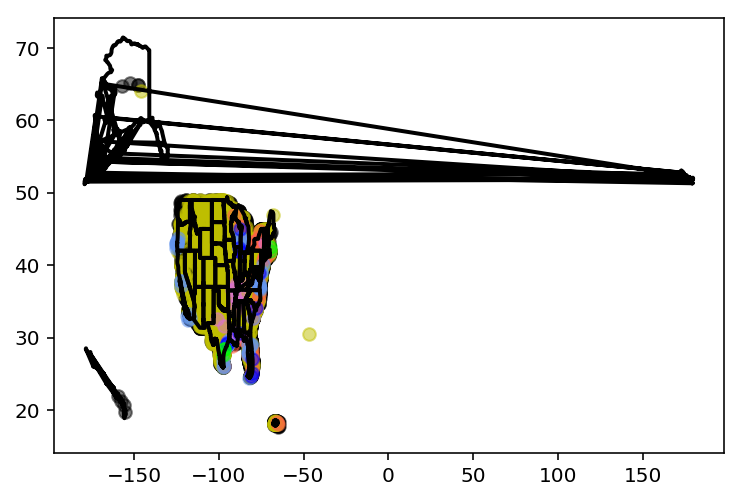

In [12]:
# checking if now all points fall inside the map
map_plot(df)

In [13]:
# checking how many observations for each phenomenon I have
df['EVENT_TYPE'].value_counts()

Thunderstorm Wind           115878
Hail                         20558
Marine Thunderstorm Wind        86
Marine Strong Wind              71
Tornado                         14
Marine High Wind                12
Marine Hail                      5
Flash Flood                      5
Name: EVENT_TYPE, dtype: int64

In [14]:
df.shape

(136629, 32)

In [15]:
df.to_csv('all_storms.csv', index = False)

In [16]:
df = df[(df['EVENT_TYPE'] == 'Hail') | (df['EVENT_TYPE'] == 'Thunderstorm Wind')]
df.to_csv('hails_and_thunderstorms.csv', index = False)
df.shape

(136436, 32)

In [17]:
for idx, row in df.iterrows():
    df.loc[idx,'BEGIN_HOUR'] = df.loc[idx,'BEGIN_TIME'].hour
    df.loc[idx,'BEGIN_MINUTE'] = df.loc[idx,'BEGIN_TIME'].minute

    df.loc[idx,'END_HOUR'] = df.loc[idx,'END_TIME'].hour
    df.loc[idx,'END_MINUTE'] = df.loc[idx,'END_TIME'].minute


df['TOTAL_DURATION_HR'] = round(df['DURATION_DAYS']*24 + df['DURATION_HOURS'] + df['DURATION_MINUTES']/60,1)
df = df[df['TOTAL_DURATION_HR'] > 0]
df.head()

,STATE,CZ_TYPE,EVENT_TYPE,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,MAGNITUDE_TYPE,MAGNITUDE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_MONTH,END_DAY,END_TIME,DURATION_DAYS,DURATION_HOURS,DURATION_MINUTES,BEGIN_HOUR,BEGIN_MINUTE,END_HOUR,END_MINUTE,TOTAL_DURATION_HR
2,MISSOURI,C,Thunderstorm Wind,2000-01-03 08:50:00,CST,03-JAN-00 09:00:00,3,0,0,0,250000.0,0.0,NaN,NaN,NaN,NaN,E,83.00,37.25,-89.67,37.30,-89.53,2000,1,3,08:50:00,1,3,09:00:00,0,0,10,8.0,50.0,9.0,0.0,0.2
3,ILLINOIS,C,Thunderstorm Wind,2000-01-03 09:18:00,CST,03-JAN-00 09:22:00,0,0,0,0,150000.0,0.0,2.0,NE,4.0,NE,E,100.00,37.73,-89.18,37.75,-89.17,2000,1,3,09:18:00,1,3,09:22:00,0,0,4,9.0,18.0,9.0,22.0,0.1
12,ARKANSAS,C,Hail,2000-01-03 12:30:00,CST,03-JAN-00 12:35:00,0,0,0,0,50.0,0.0,NaN,NaN,NaN,NaN,HA,0.88,35.87,-90.95,35.87,-90.95,2000,1,3,12:30:00,1,3,12:35:00,0,0,5,12.0,30.0,12.0,35.0,0.1
13,ARKANSAS,C,Hail,2000-01-03 12:38:00,CST,03-JAN-00 12:55:00,0,0,0,0,750.0,0.0,NaN,NaN,2.0,W,HA,1.75,36.03,-90.67,36.05,-90.52,2000,1,3,12:38:00,1,3,12:55:00,0,0,17,12.0,38.0,12.0,55.0,0.3
14,ARKANSAS,C,Hail,2000-01-03 12:48:00,CST,03-JAN-00 12:55:00,0,0,0,0,10.0,0.0,NaN,NaN,NaN,NaN,HA,0.75,36.33,-90.38,36.33,-90.38,2000,1,3,12:48:00,1,3,12:55:00,0,0,7,12.0,48.0,12.0,55.0,0.1


In [18]:
# define a function that calculates the distance between two points on the Earth surface, given
# their latitude and longitude
def distance(lat1,lon1,lat2,lon2):
    
    # transforming longitude and latitude to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # latitude and longitude difference
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # radius of the Earth in km
    R = 6373 
    
    # multipliers 
    a = np.power(np.sin(dlat), 2) + np.multiply(np.cos(lat1), np.multiply(np.cos(lat2), np.power(np.sin(dlon/2), 2)))
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

In [19]:
for index, row in df.iterrows():
    df.loc[index,'DISTANCE_COVERED(KM)'] = distance(row['BEGIN_LAT'], row['BEGIN_LON'], row['END_LAT'], row['END_LON'])

In [20]:
df.shape

(32168, 38)

In [21]:
df.isnull().sum()

STATE                      0
CZ_TYPE                    0
EVENT_TYPE                 0
BEGIN_DATE_TIME            0
CZ_TIMEZONE                0
END_DATE_TIME              0
INJURIES_DIRECT            0
INJURIES_INDIRECT          0
DEATHS_DIRECT              0
DEATHS_INDIRECT            0
DAMAGE_PROPERTY            0
DAMAGE_CROPS               0
BEGIN_RANGE             7049
BEGIN_AZIMUTH           7049
END_RANGE               7061
END_AZIMUTH             7061
MAGNITUDE_TYPE             0
MAGNITUDE                  0
BEGIN_LAT                  0
BEGIN_LON                  0
END_LAT                    0
END_LON                    0
YEAR                       0
BEGIN_MONTH                0
BEGIN_DAY                  0
BEGIN_TIME                 0
END_MONTH                  0
END_DAY                    0
END_TIME                   0
DURATION_DAYS              0
DURATION_HOURS             0
DURATION_MINUTES           0
BEGIN_HOUR                 0
BEGIN_MINUTE               0
END_HOUR      

In [22]:
# columns with missing values
fields_to_fill = ['BEGIN_RANGE', 'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH']

# iterating over the columns with missing values
for field in fields_to_fill:
    
    # define a subset with no missing values
    df_complete = df.loc[df[field].isnull() == False,:]
    
    # and a subset with all missing values in the column I am considering
    df_to_complete = df.loc[df[field].isnull(),:]
    
    # for each row of the df with the missing value
    for index, row in df_to_complete.iterrows():
        
        # create a column with the values of distance between the point I am considering and all the points
        # in the df with no missing values. Depending on whether I am iterating over BEGIN or END columns,
        # I will consider BEGIN or END latitude and longitude values
        if field.startswith('BEGIN'):
            df_complete['dist'] = distance(row['BEGIN_LAT'], row['BEGIN_LON'], df_complete['BEGIN_LAT'], df_complete['BEGIN_LON'])
        else:
            df_complete['dist'] = distance(row['END_LAT'], row['END_LON'], df_complete['END_LAT'], df_complete['END_LON'])
        
        # getting the index of the row with the shortest distance
        idx = df_complete['dist'].idxmin()
        
        # assignign to the missing observation the value of its closest point 
        df.loc[index,field] = df_complete.loc[idx,field]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
df.isnull().sum()

STATE                   0
CZ_TYPE                 0
EVENT_TYPE              0
BEGIN_DATE_TIME         0
CZ_TIMEZONE             0
END_DATE_TIME           0
INJURIES_DIRECT         0
INJURIES_INDIRECT       0
DEATHS_DIRECT           0
DEATHS_INDIRECT         0
DAMAGE_PROPERTY         0
DAMAGE_CROPS            0
BEGIN_RANGE             0
BEGIN_AZIMUTH           0
END_RANGE               0
END_AZIMUTH             0
MAGNITUDE_TYPE          0
MAGNITUDE               0
BEGIN_LAT               0
BEGIN_LON               0
END_LAT                 0
END_LON                 0
YEAR                    0
BEGIN_MONTH             0
BEGIN_DAY               0
BEGIN_TIME              0
END_MONTH               0
END_DAY                 0
END_TIME                0
DURATION_DAYS           0
DURATION_HOURS          0
DURATION_MINUTES        0
BEGIN_HOUR              0
BEGIN_MINUTE            0
END_HOUR                0
END_MINUTE              0
TOTAL_DURATION_HR       0
DISTANCE_COVERED(KM)    0
dtype: int64

### Saving the dataframe that I will use for predictions. It contains only hails and thunderstorms observations, with both time duration and economic damage greater than 0.

In [24]:
df.to_csv('final.csv')

# 2. EDA

Check my interacrive plot at this link:

In [69]:
storms = pd.read_csv('all_storms.csv')
places_to_drop = ['LAKE SUPERIOR','LAKE ERIE','ST LAWRENCE R','LAKE ST CLAIR','LAKE ONTARIO','ATLANTIC SOUTH','E PACIFIC',
'ATLANTIC NORTH','GULF OF MEXICO','LAKE MICHIGAN']
for place in places_to_drop:
    for idx, row in storms.iterrows():
        if row['STATE'] == place:
            storms.drop([idx], inplace = True)
storms.shape

(136455, 32)

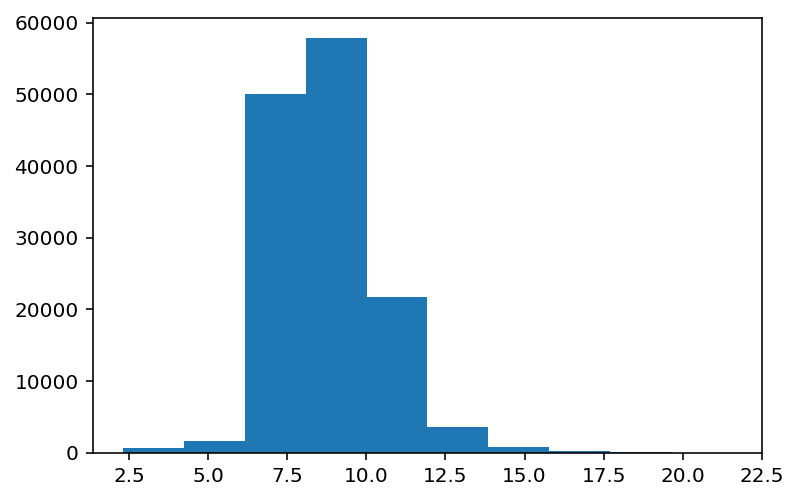

In [70]:
plt.hist(np.log(storms['DAMAGE_PROPERTY']));

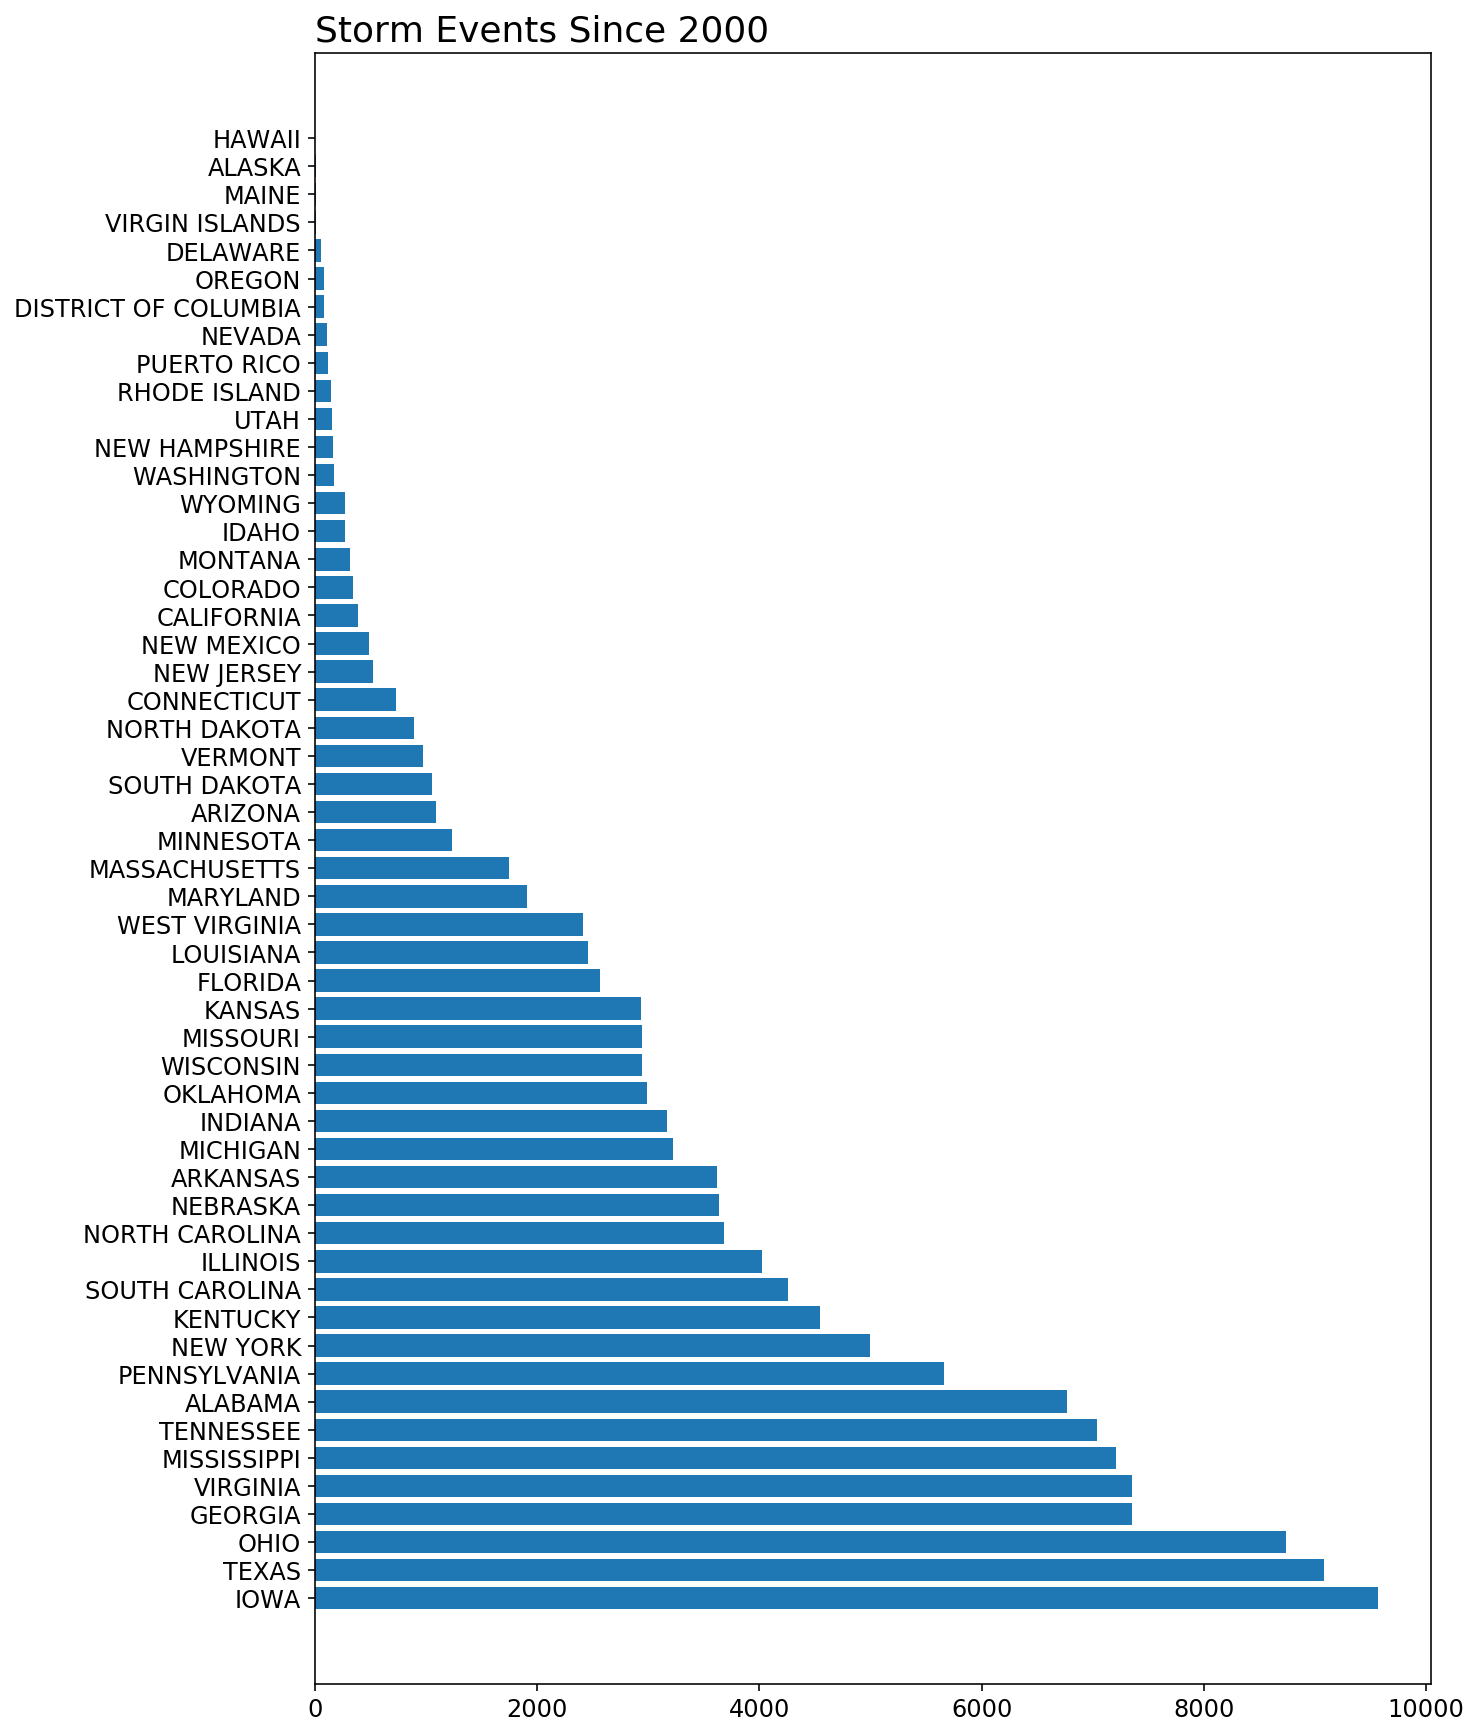

In [71]:

plt.figure(figsize=(10,15))
plt.barh(storms['STATE'].value_counts().sort_values(ascending = False).index,
         storms['STATE'].value_counts().sort_values(ascending = False).values)
plt.title('Storm Events Since 2000', fontsize = 18, ha = 'left', x = 0)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12);

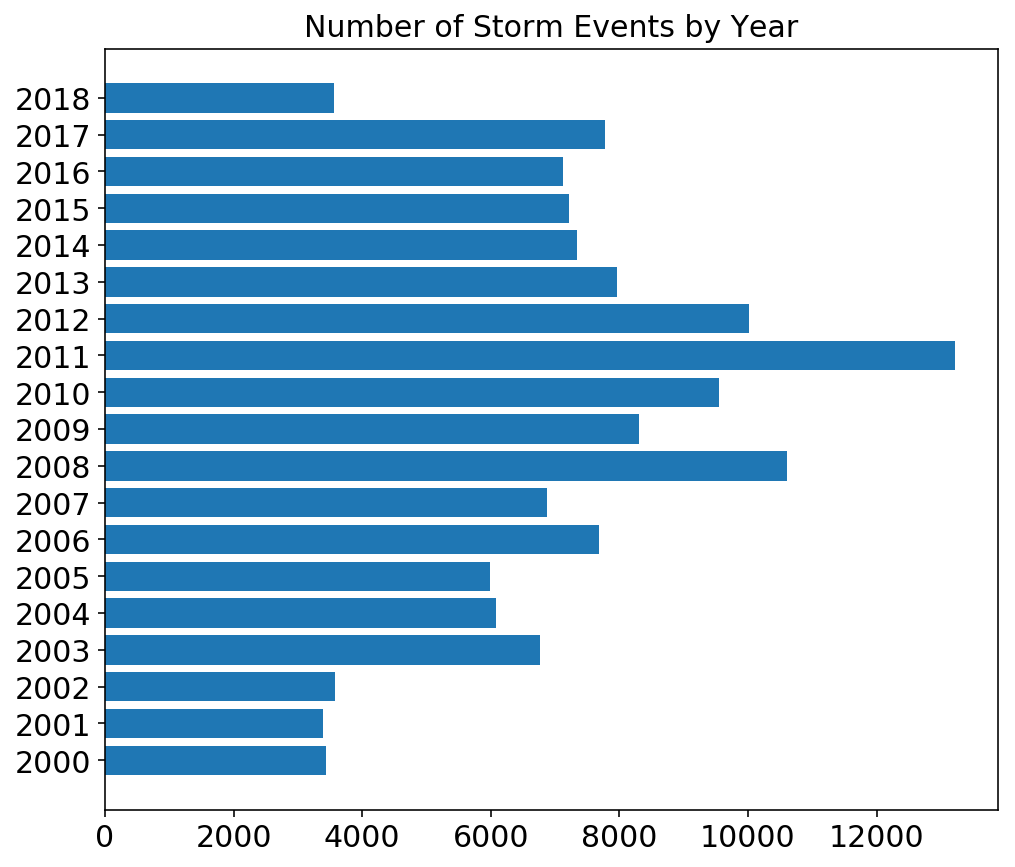

In [72]:
plt.figure(figsize=(8,7))
#plt.bar(df['YEAR'].value_counts().sort_index().index, df['YEAR'].value_counts().sort_index().values)
plt.barh(storms['YEAR'].value_counts().sort_index().index, storms['YEAR'].value_counts().sort_index().values)

plt.title('Number of Storm Events by Year', fontsize = 15)
plt.yticks(np.arange(2000,2019,1), fontsize = 15)
plt.xticks(fontsize = 15);

In [73]:
storms.loc[storms['YEAR'] == 2018,'BEGIN_MONTH'].max()

6

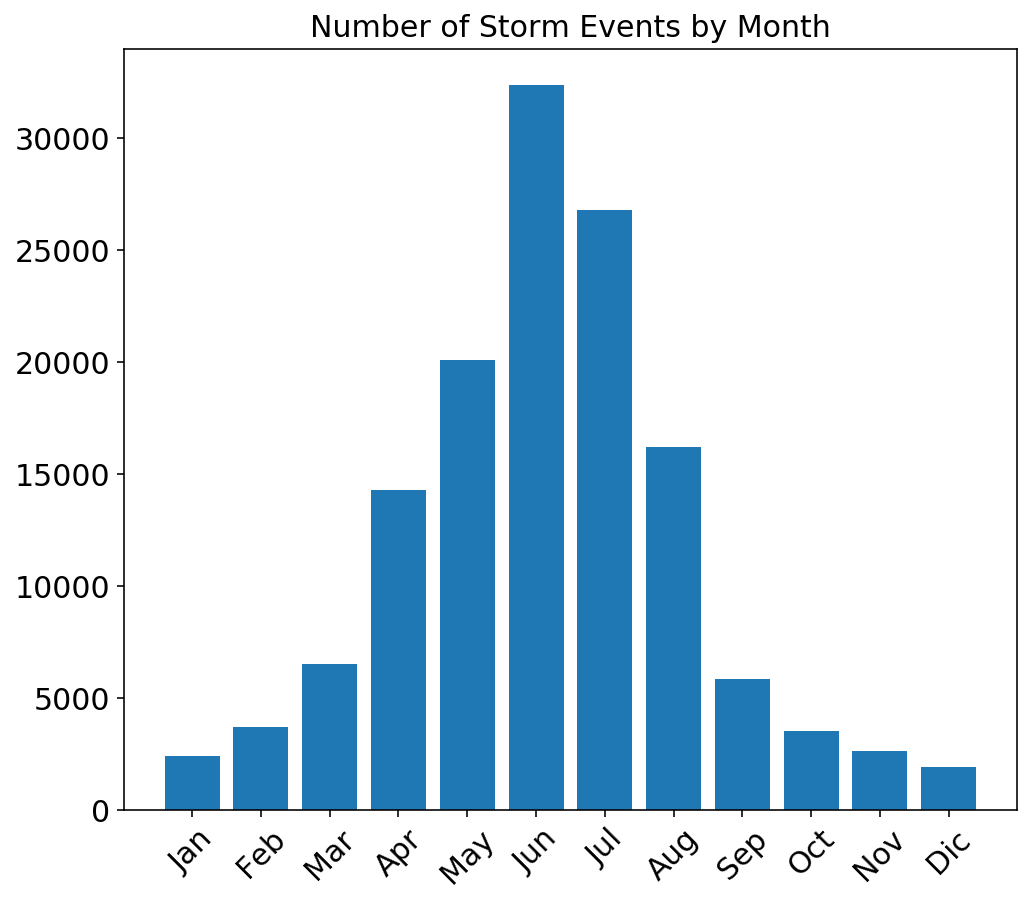

In [74]:
plt.figure(figsize=(8,7))
plt.bar(storms['BEGIN_MONTH'].value_counts().sort_index().index, storms['BEGIN_MONTH'].value_counts().sort_index().values)
plt.title('Number of Storm Events by Month', fontsize = 15)
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dic'],
           rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15);

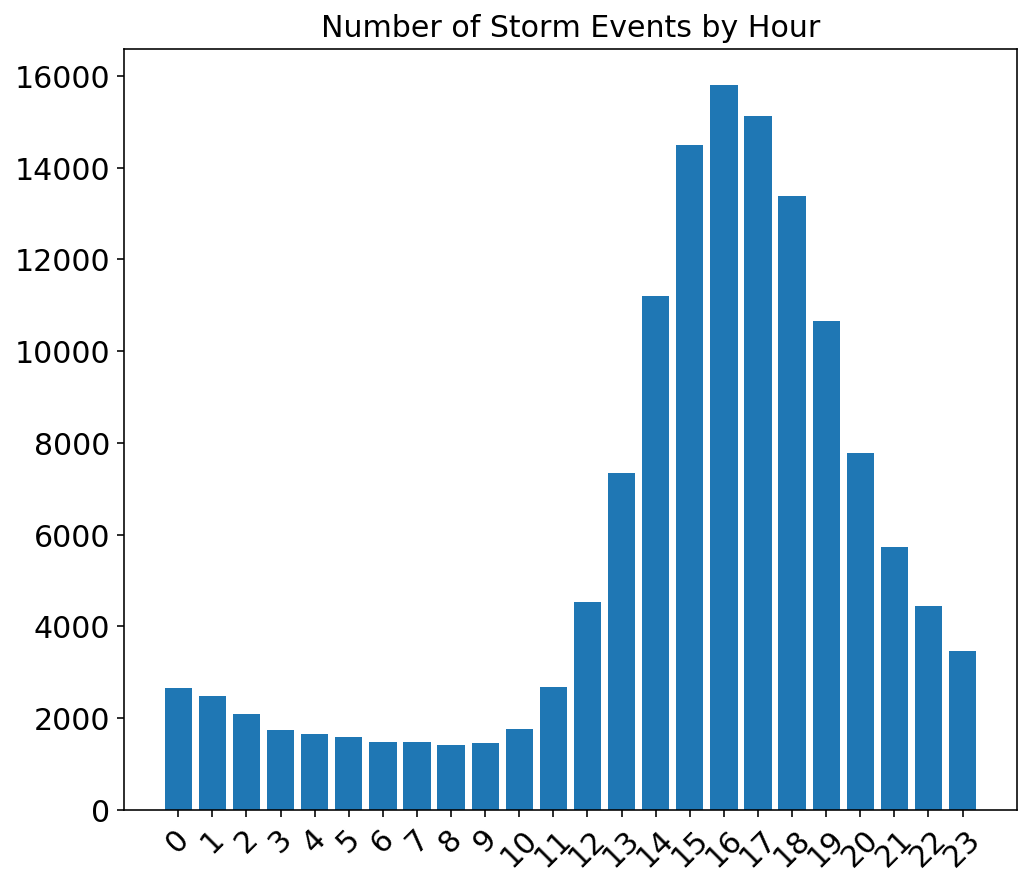

In [75]:
plt.figure(figsize=(8,7))
plt.bar(pd.to_datetime(storms['BEGIN_TIME']).dt.hour.value_counts().sort_index().index,
        pd.to_datetime(storms['BEGIN_TIME']).dt.hour.value_counts().sort_index().values)
plt.title('Number of Storm Events by Hour', fontsize = 15)
plt.xticks(range(0,24), fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15);   

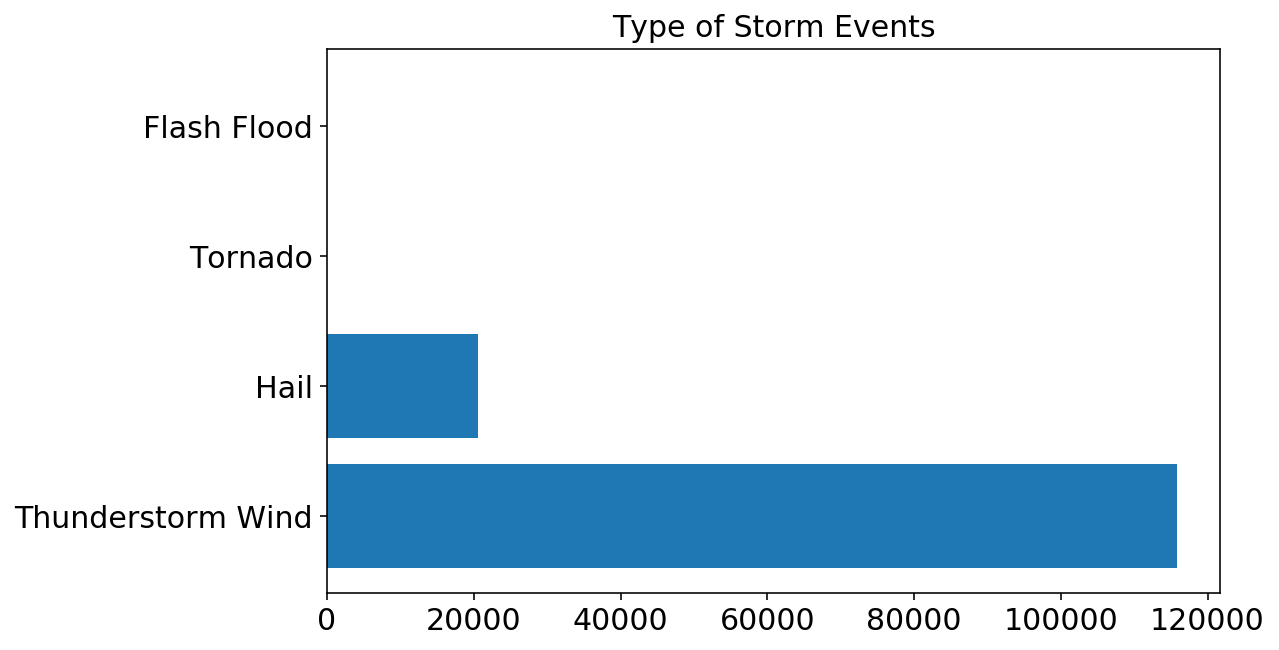

In [76]:
plt.figure(figsize=(8,5))
plt.barh(storms['EVENT_TYPE'].value_counts().index, storms['EVENT_TYPE'].value_counts().values)
plt.title('Type of Storm Events', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

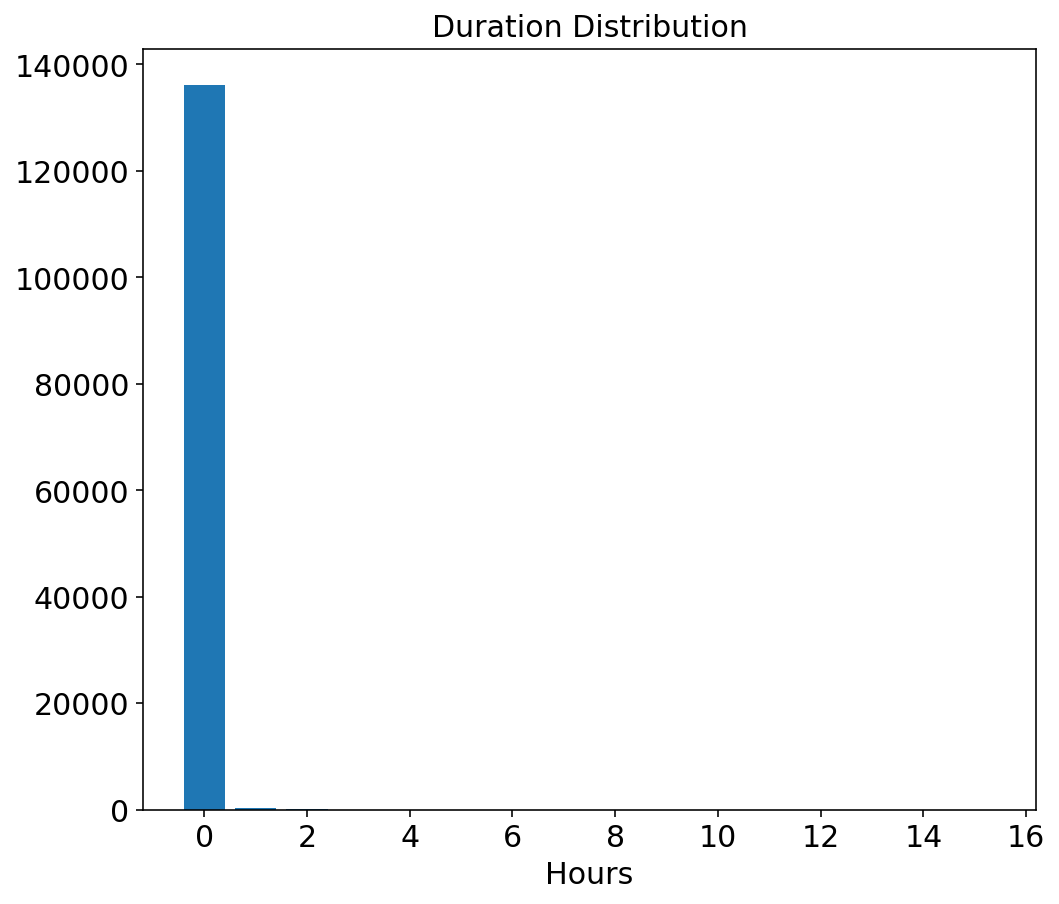

In [61]:
plt.figure(figsize=(8,7))
plt.bar(storms['DURATION_HOURS'].value_counts().sort_index().index,
        storms['DURATION_HOURS'].value_counts().sort_index().values)
plt.title('Duration Distribution', fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('Hours', fontsize = 15)
plt.yticks(fontsize = 15);

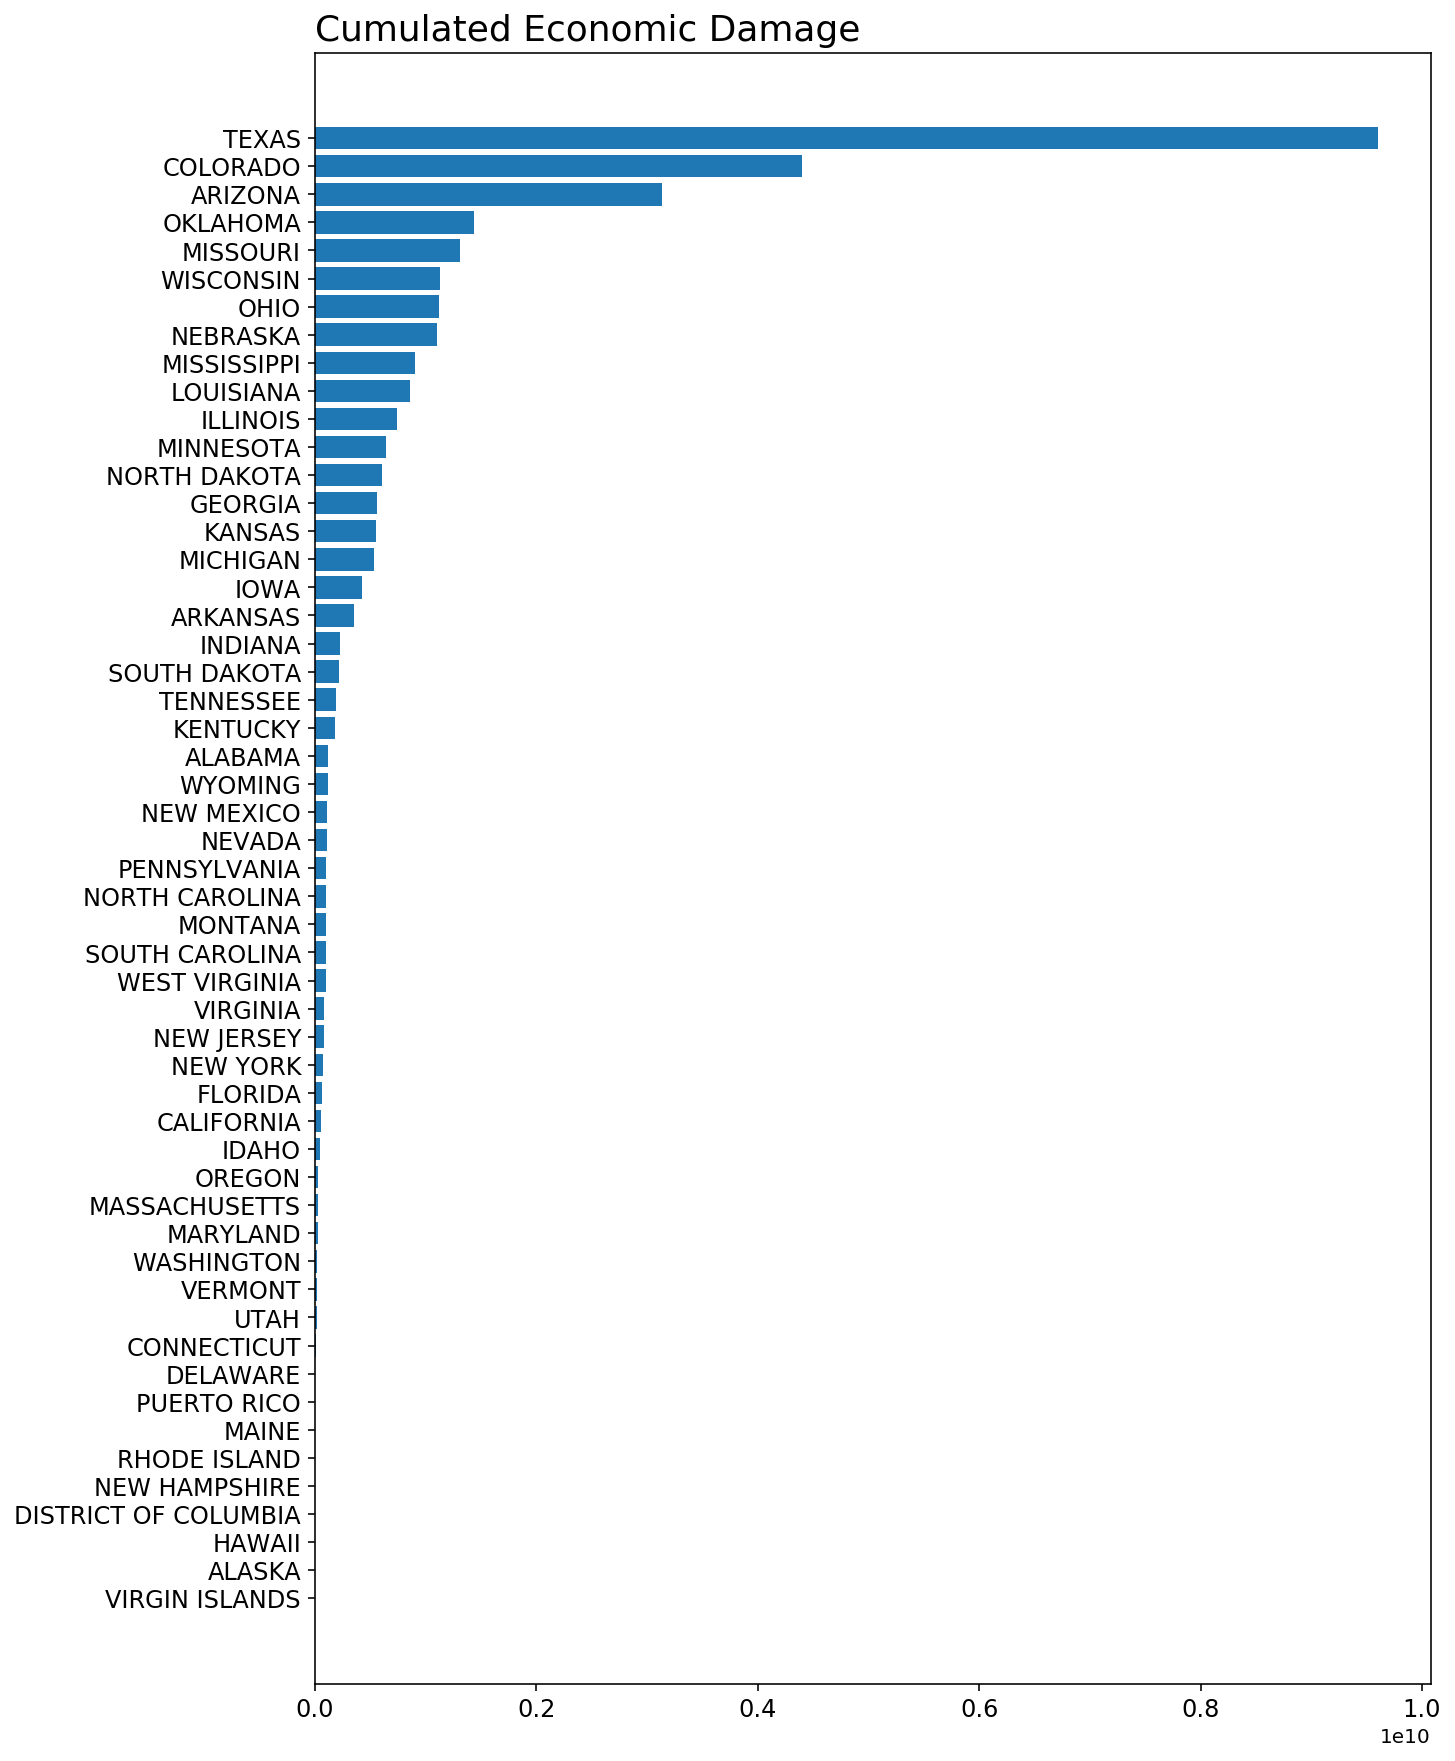

In [77]:
plt.figure(figsize=(10,15))
plt.barh(storms.groupby('STATE').sum()['DAMAGE_PROPERTY'].sort_values().index,
         storms.groupby('STATE').sum()['DAMAGE_PROPERTY'].sort_values().values)
plt.title('Cumulated Economic Damage', fontsize = 18, ha = 'left', x = 0)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12);

In [78]:
hail = df.loc[df['EVENT_TYPE'] == 'Hail']
thun = df.loc[df['EVENT_TYPE'] == 'Thunderstorm Wind']

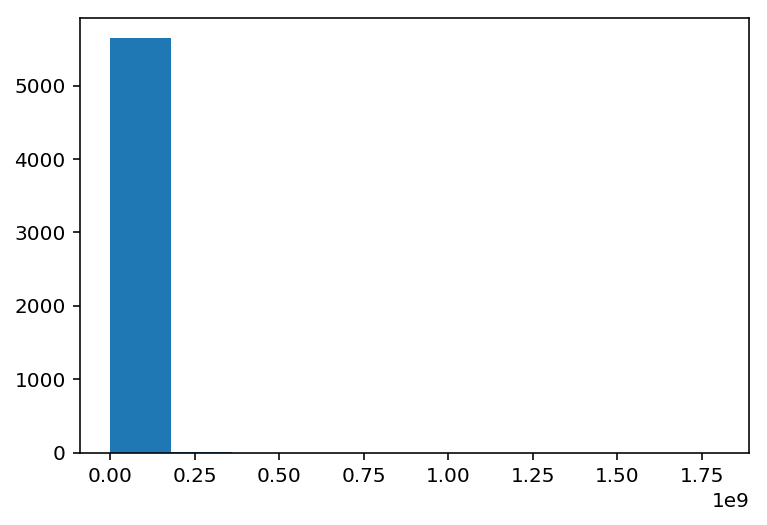

In [79]:
plt.hist(hail['DAMAGE_PROPERTY']);

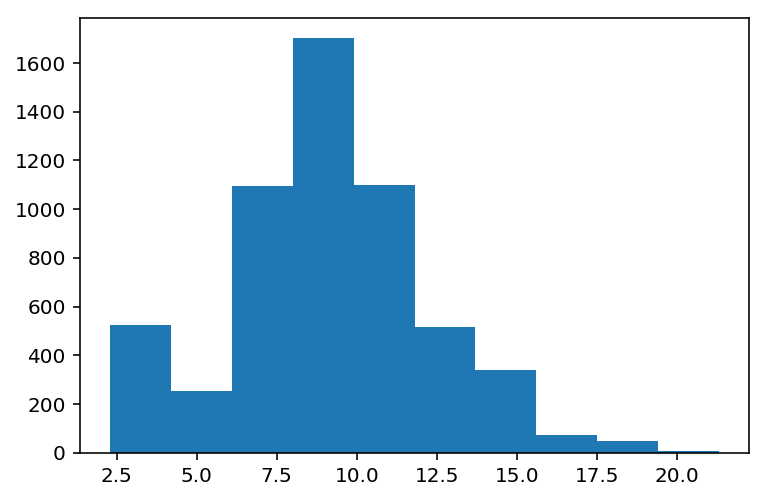

In [80]:
plt.hist(np.log(hail['DAMAGE_PROPERTY']));

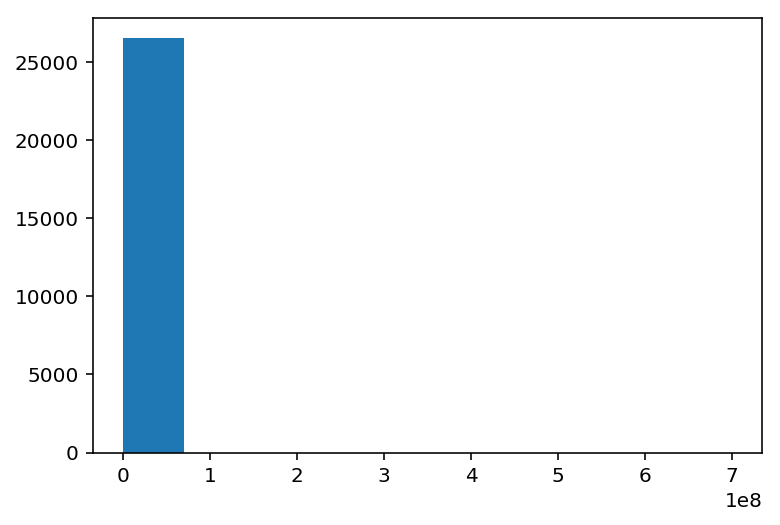

In [81]:
plt.hist(thun['DAMAGE_PROPERTY']);

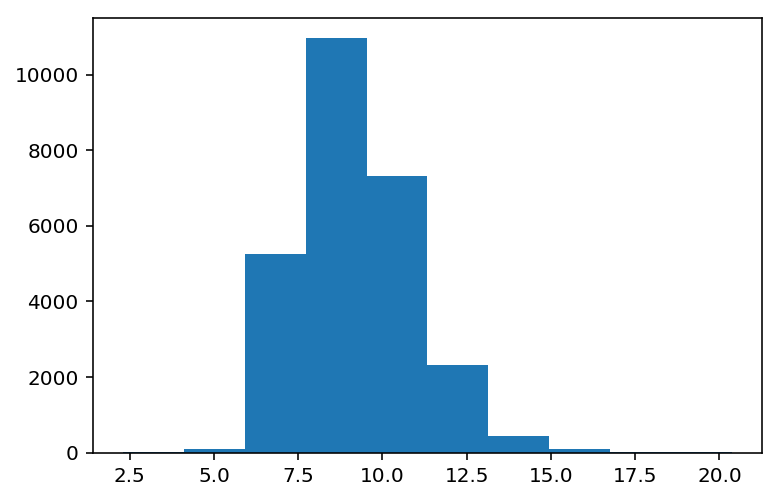

In [82]:
plt.hist(np.log(thun['DAMAGE_PROPERTY']));

In [83]:
print(df.columns)
features = ['STATE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'MAGNITUDE', 'BEGIN_MONTH', 'DISTANCE_COVERED(KM)', 
            'BEGIN_HOUR', 'TOTAL_DURATION_HR']

Index(['STATE', 'CZ_TYPE', 'EVENT_TYPE', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE',
       'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT',
       'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS',
       'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH',
       'MAGNITUDE_TYPE', 'MAGNITUDE', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', 'YEAR', 'BEGIN_MONTH', 'BEGIN_DAY', 'BEGIN_TIME',
       'END_MONTH', 'END_DAY', 'END_TIME', 'DURATION_DAYS', 'DURATION_HOURS',
       'DURATION_MINUTES', 'BEGIN_HOUR', 'BEGIN_MINUTE', 'END_HOUR',
       'END_MINUTE', 'TOTAL_DURATION_HR', 'DISTANCE_COVERED(KM)'],
      dtype='object')


In [84]:
# function to calculate r^2 of my neural network
def r_square_log(X_test,y_test):
    y_pred = model.predict(X_test).reshape(y_test.shape[0])
    y_test = np.array(y_test)
    ss_res = np.sum(np.square(y_test - y_pred))
    y_mean = np.full((1, y_test.shape[0]),y_test.mean())
    ss_tot = np.sum(np.square(y_mean - y_test))
    return 1-ss_res/ss_tot

In [85]:
def r_square(X_test,y_test):
    y_pred = np.exp(model.predict(X_test)).reshape(y_test.shape[0])
    y_test = np.array(np.exp(y_test))
    ss_res = np.sum(np.square(y_test - y_pred))
    y_mean = np.full((1, y_test.shape[0]),y_test.mean())
    ss_tot = np.sum(np.square(y_mean - y_test))
    return 1-ss_res/ss_tot

# 3.Predictive models

## HAILS

In [ ]:
X = hail[features]
X = pd.get_dummies(X)
y = np.log(hail['DAMAGE_PROPERTY'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X.shape

In [ ]:
model = Sequential()

# input layer 
model.add(Dense(X_train.shape[1], activation = 'relu', input_dim = X_train.shape[1]))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.3))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.3))

# output layer
model.add(Dense(1, activation = None))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 500, verbose = 0)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend();

In [ ]:
r_square_log(X_test, y_test)

In [ ]:
r_square_log(X_train, y_train)

## THUNDERSTORMS

In [ ]:
X = thun[features]
X = pd.get_dummies(X)
y = np.log(thun['DAMAGE_PROPERTY'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X.shape

In [ ]:
model = Sequential()

# input layer 
model.add(Dense(X.shape[1], activation = 'relu', input_dim = X_train.shape[1]))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.3))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.3))

# output layer
model.add(Dense(1, activation = None))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 500, verbose = 0, batch_size = 2000)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend();

In [ ]:
r_square_log(X_test, y_test)

In [ ]:
r_square_log(X_train, y_train)